# **1 - Coco Dataset**

In [1]:
import os
import cv2
import json
import math
import pprint
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip

--2023-10-21 16:18:10--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.25.148, 3.5.25.45, 52.216.8.131, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.25.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.2MB/s    in 2.5s    

2023-10-21 16:18:13 (96.2 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [3]:
train_ann = '/content/annotations/instances_train2017.json'
val_ann = '/content/annotations/instances_val2017.json'

!mkdir train
!mkdir validation

train_annotation = '/content/train/annotations/train2017.json'
val_annotation = '/content/validation/annotations/val2017.json'

train_images = '/content/train/images/'
val_images = '/content/validation/images/'

train_mask = '/content/train/masks/'
val_mask = '/content/validation/masks/'

In [4]:
def getCocoDataset(annotation_path, image_path, object_class, limit=None):
  coco = COCO(annotation_path)

  catIds = coco.getCatIds(catNms=[object_class])
  imgIds = coco.getImgIds(catIds=catIds)
  images = coco.loadImgs(imgIds)

  os.makedirs(image_path, exist_ok=True)

  for i, im in enumerate(images):
    if i == limit:
      break
    img_data = requests.get(im['coco_url']).content
    with open(image_path + im['file_name'], 'wb') as handler:
        handler.write(img_data)

In [5]:
getCocoDataset(train_ann, train_images, 'horse', 800)
getCocoDataset(val_ann, val_images, 'horse', 200)

loading annotations into memory...
Done (t=18.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [6]:
def filterAnnotation(annotation_path, image_path, output_path):
  coco = COCO(annotation_path)

  images = os.listdir(image_path)

  os.makedirs('/'.join(output_path.split('/')[:-1]), exist_ok=True)

  filtered_annotations = {
    "images": [],
    "annotations": [],
    "categories": coco.dataset["categories"]
  }

  # Iterate through images and annotations
  for image_id in coco.getImgIds():
      image_info = coco.loadImgs([image_id])[0]
      if image_info['file_name'] in images:
          filtered_annotations["images"].append(image_info)
          annotations = coco.imgToAnns[image_id]
          filtered_annotations["annotations"].extend(annotations)

  # Save the filtered annotations to a new JSON file
  with open(output_path, 'w') as f:
      json.dump(filtered_annotations, f)


In [7]:
filterAnnotation(train_ann, train_images, train_annotation)
filterAnnotation(val_ann, val_images, val_annotation)

loading annotations into memory...
Done (t=15.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!


# **2 - Generaing Masks**

In [25]:
def generate_segmentation_masks(annotation_path, output_dir):

    coco = COCO(annotation_path)

    os.makedirs(output_dir, exist_ok=True)

    img_ids = coco.getImgIds()

    min_height, min_width = math.inf, math.inf

    for img_id in img_ids:
        img_info = coco.loadImgs([img_id])[0]

        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        # Initialize a blank mask
        height = img_info['height']
        width = img_info['width']
        mask = np.zeros((height, width))

        min_height = min(min_height, height)
        min_width = min(min_width, width)

        # Generate the mask by drawing polygons for each annotation
        for annotation in annotations:

            if annotation['category_id'] != 19:
              continue
            rle = maskUtils.frPyObjects(annotation['segmentation'],
                                        img_info['height'],
                                        img_info['width'])
            decoded_mask = maskUtils.decode(rle)
            if len(decoded_mask.shape) > 2:
              decoded_mask = decoded_mask[:, :, 0]
            mask += decoded_mask

        # Save the mask as an image
        mask_filename = os.path.join(output_dir,
                                     img_info['file_name'].replace('jpg', 'png'))
        cv2.imwrite(mask_filename, mask.astype(np.uint8) * 255)

    return min_height, min_width

In [ ]:
height1, width1 = generate_segmentation_masks(train_annotation, train_mask)
height2, width2 = generate_segmentation_masks(val_annotation, val_mask)

height = min(height1, height2)
width = min(width1, width2)

# **3 - U-Net**

In [10]:
import torch
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from collections import defaultdict
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Output layer
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        skip_connections = []
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            # print(x.shape)
            if i%7 == 5:
                skip_connections.append(x)

        skip_connections.pop()
        # print([x.shape for x in skip_connections])
        # Decoder
        for i in range(0, len(self.decoder), 8):
            # print('Before Trans   ',x.shape)
            x = self.decoder[i](x)
            # print('After  Trans   ',x.shape)
            x = torch.cat([x, skip_connections.pop()], dim=1)
            # print('Cat            ',x.shape)
            x = self.decoder[i+1](x)
            # print('Relu           ',x.shape)
            x = self.decoder[i+4](self.decoder[i+3](self.decoder[i+2](x)))
            # print('First Conv     ',x.shape)
            x = self.decoder[i+7](self.decoder[i+6](self.decoder[i+5](x)))
            # print('Second Conv    ',x.shape)

        # Output layer
        x = self.outconv(x)
        return x

In [59]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('jpg', 'png'))


        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [60]:
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor()])
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                #                      std=[0.229, 0.224, 0.225])])

train_dataset = CustomDataset(train_images, train_mask, transform=transform)
val_dataset = CustomDataset(val_images, val_mask, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [61]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=1).to(device)

num_epochs = 10
learning_rate = 1e-4

In [62]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

In [63]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = nn.BCEWithLogitsLoss()(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

In [64]:
def train_unet(model, train_loader, val_loader, num_epochs, learning_rate, device, save_path=None, patience=5):
    # criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
    metrics = defaultdict(float)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)


    best_val_loss = float('inf')
    best_model_state = None
    early_stopping_counter = 0

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1} (Train)"):
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # outputs = torch.sigmoid(outputs)
            # loss = criterion(outputs, masks)
            loss = calc_loss(outputs, masks, metrics)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, masks in tqdm(val_loader, desc=f"Epoch {epoch + 1} (Val)"):
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                # outputs = torch.sigmoid(outputs)
                # loss = criterion(outputs, masks)
                loss = calc_loss(outputs, masks, metrics)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            if save_path:
                torch.save(model.state_dict(), save_path)
            early_stopping_counter = 0  # Reset the counter
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping after {epoch + 1} epochs without improvement.")
            break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model

In [65]:
trained_model = train_unet(model, train_dataloader, val_dataloader, num_epochs, learning_rate, device, save_path='/content/best_model.pth', patience=3)

Epoch 1 (Val): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]


Epoch 1/10 - Train Loss: 0.7356 - Validation Loss: 0.6707


Epoch 2 (Val): 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]


Epoch 2/10 - Train Loss: 0.6250 - Validation Loss: 0.5977


Epoch 3 (Val): 100%|██████████| 16/16 [00:04<00:00,  3.98it/s]


Epoch 3/10 - Train Loss: 0.5895 - Validation Loss: 0.5851


Epoch 4 (Val): 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]


Epoch 4/10 - Train Loss: 0.5660 - Validation Loss: 0.6393


Epoch 5 (Val): 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]


Epoch 5/10 - Train Loss: 0.5470 - Validation Loss: 0.5557


Epoch 6 (Val): 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]


Epoch 6/10 - Train Loss: 0.5273 - Validation Loss: 0.5430


Epoch 7 (Val): 100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


Epoch 7/10 - Train Loss: 0.5103 - Validation Loss: 0.5085


Epoch 8 (Val): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]


Epoch 8/10 - Train Loss: 0.4981 - Validation Loss: 0.4989


Epoch 9 (Val): 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


Epoch 9/10 - Train Loss: 0.4846 - Validation Loss: 0.5113


Epoch 10 (Val): 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


Epoch 10/10 - Train Loss: 0.4687 - Validation Loss: 0.4851


In [34]:
!wget https://encrypted-tbn1.gstatic.com/licensed-image?q=tbn:ANd9GcSOD2yS2nqNxhV09Kk4fbOZw6sEuH1cxAZifXRS25GZccRScRYcJ9khSpuwW9uZmowN8qgc3zIL5_2PKb0 -O horse.jpg

--2023-10-21 16:35:55--  https://encrypted-tbn1.gstatic.com/licensed-image?q=tbn:ANd9GcSOD2yS2nqNxhV09Kk4fbOZw6sEuH1cxAZifXRS25GZccRScRYcJ9khSpuwW9uZmowN8qgc3zIL5_2PKb0
Resolving encrypted-tbn1.gstatic.com (encrypted-tbn1.gstatic.com)... 172.253.119.101, 172.253.119.113, 172.253.119.102, ...
Connecting to encrypted-tbn1.gstatic.com (encrypted-tbn1.gstatic.com)|172.253.119.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262790 (257K) [image/jpeg]
Saving to: ‘horse.jpg’

horse.jpg           100%[===================>] 256.63K  --.-KB/s    in 0.002s  

2023-10-21 16:35:55 (111 MB/s) - ‘horse.jpg’ saved [262790/262790]



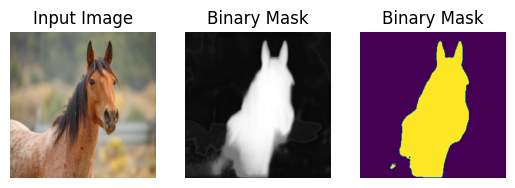

In [69]:
trained_model.eval()

original_image = Image.open('/content/horse.jpg')

original_image = transform(original_image).unsqueeze(0)

with torch.no_grad():
    predicted_mask_original = model(original_image.to('cuda'))

predicted_mask_sig = torch.sigmoid(predicted_mask_original)


plt.subplot(1, 3, 1)
plt.imshow(np.array(original_image.squeeze(0).permute(1, 2, 0)) )
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_sig.cpu().numpy().squeeze(), cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

predicted_mask_sig[predicted_mask_sig>0.5] = 1
predicted_mask_sig[predicted_mask_sig<0.5] = 0

plt.subplot(1, 3, 3)
# plt.imshow(predicted_mask_sig.cpu().numpy().squeeze(), cmap='gray')
plt.imshow(predicted_mask_sig.cpu().numpy().squeeze())
plt.title('Binary Mask')
plt.axis('off')

plt.show()